Установка зависимостей

In [ ]:
%pip install darts==0.28.0
%pip install pandas==2.2.1
%pip install matplotlib==3.8.3
%pip install scikit-learn==1.4.0

Загрузка данных

In [10]:
import pandas as pd
from datetime import datetime

df = pd.read_csv("dataset-ts/dollar.csv")
df = df.drop(columns=["bullet", "bulletClass", "label"])
df = df.rename(columns={"my_date": "date", "my_value": "value"})
df["date"] = df.apply(lambda row: datetime.strptime(row["date"], "%d.%m.%Y"), axis=1)

df.head()

,date,value
0,2023-03-28,76.5662
1,2023-03-31,77.0863
2,2023-04-01,77.3233
3,2023-04-04,77.9510
4,2023-04-05,79.3563


Создание временного ряда из набора данных

<Axes: xlabel='date'>

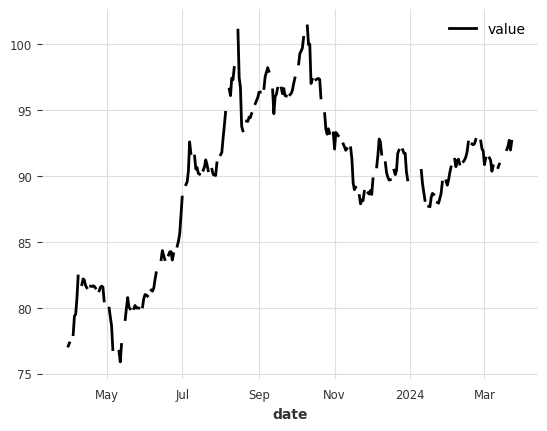

In [19]:
from darts import TimeSeries

series = TimeSeries.from_dataframe(
    df, "date", "value", fill_missing_dates=True, freq="D")

series.plot()

Заполнение пропущенных значений

<Axes: xlabel='date'>

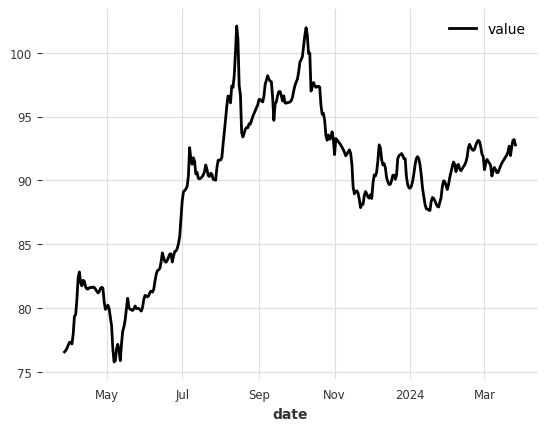

In [21]:
from darts.dataprocessing.transformers import MissingValuesFiller

filler = MissingValuesFiller()
filled_series = filler.transform(series, method="quadratic")

filled_series.plot()

<Axes: xlabel='date'>

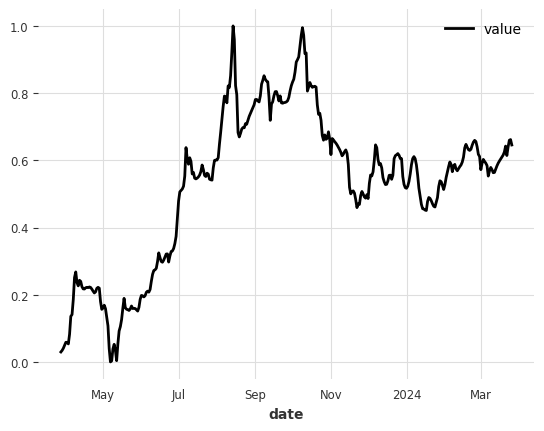

In [188]:
from darts.dataprocessing.transformers import Scaler

scaler = Scaler()
rescaled_series = scaler.fit_transform(filled_series)

rescaled_series.plot()

Создание обучающей и тестовой выборки

In [189]:
train, val = filled_series.split_before(pd.Timestamp("20240101"))
train_sc, val_sc = rescaled_series.split_before(pd.Timestamp("20240101"))

print(len(filled_series))
print(len(train))
print(len(val))

365
279
86


In [159]:
import matplotlib.pyplot as plt
from darts.utils.timeseries_generation import datetime_attribute_timeseries

future_cov = datetime_attribute_timeseries(
    train, "day", cyclic=False, add_length=len(val)
)

Обучение и визуализация результатов

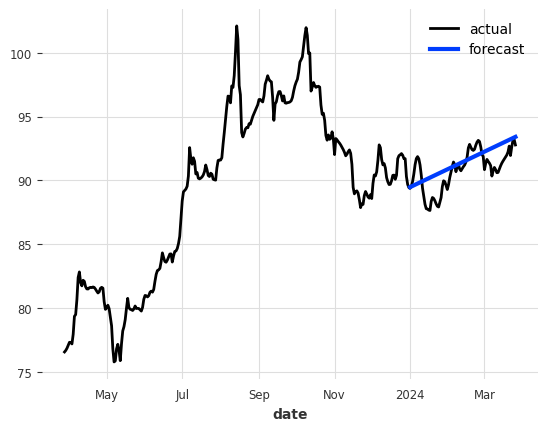

In [160]:
from darts.models import NaiveDrift

model_naive = NaiveDrift()
model_naive.fit(train)
prediction_naive = model_naive.predict(len(val))

filled_series.plot(label="actual")
prediction_naive.plot(label="forecast", lw=3)
plt.legend()

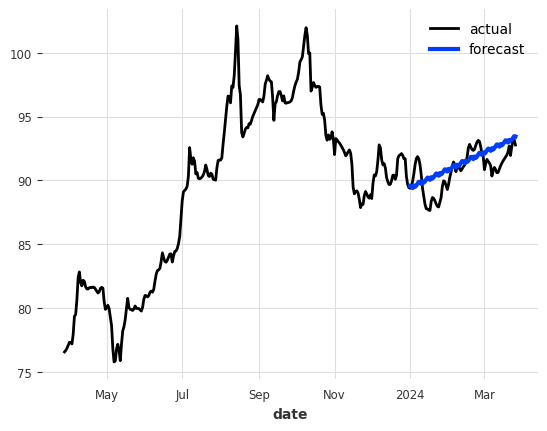

In [153]:
from darts.models import ExponentialSmoothing

model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val))

filled_series.plot(label="actual")
prediction.plot(label="forecast", lw=3)
plt.legend()

c:\Users\user\Projects\python\iias\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\user\Projects\python\iias\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\user\Projects\python\iias\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


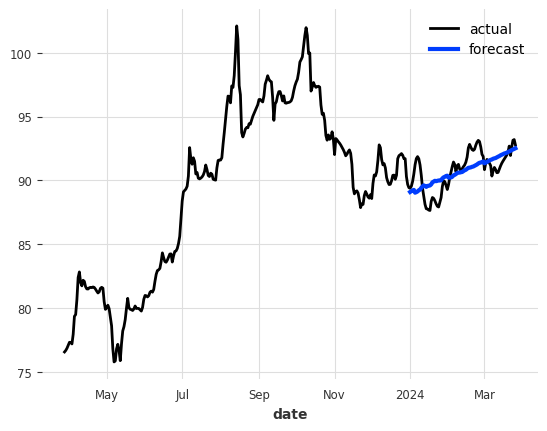

In [156]:
from darts.models import ARIMA

model_arima = ARIMA(p=10, d=2, q=10)
model_arima.fit(train, future_covariates=future_cov)
prediction_arima = model_arima.predict(len(val), future_covariates=future_cov)

filled_series.plot(label="actual")
prediction_arima.plot(label="forecast", lw=3)
plt.legend()

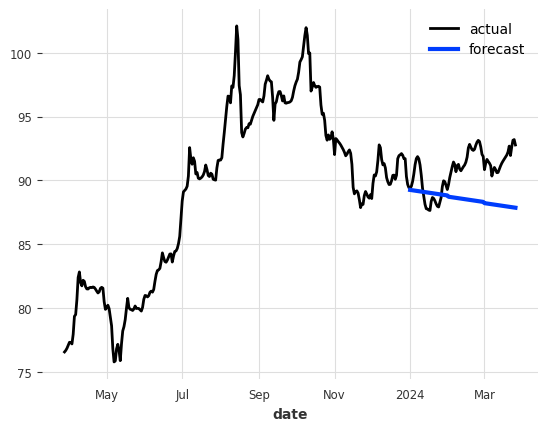

In [158]:
from darts.models import AutoARIMA

model_aarima = AutoARIMA(start_p=5, max_p=30, start_q=5, max_q=30, d=2)
model_aarima.fit(train, future_covariates=future_cov)
prediction_aarima = model_aarima.predict(len(val), future_covariates=future_cov)

filled_series.plot(label="actual")
prediction_aarima.plot(label="forecast", lw=3)
plt.legend()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 1.8 K 
4 | V             | Linear           | 21    
---------------------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.007     Total estimated model params size (MB)
c:\Users\user\Projects\python\iias\.venv\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

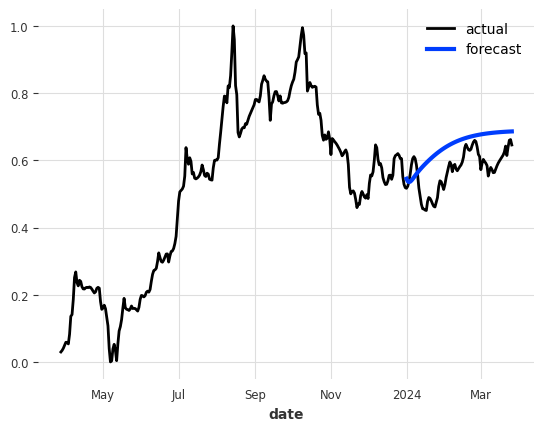

In [197]:
from darts.models import RNNModel

model_rnn = RNNModel(
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=50,
    optimizer_kwargs={"lr": 1e-3},
    model_name="Air_RNN",
    log_tensorboard=True,
    random_state=42,
    training_length=len(val_sc),
    input_chunk_length=len(val_sc) * 2,
    force_reset=True,
    save_checkpoints=True,
)
model_rnn.fit(train_sc)
prediction_rnn = model_rnn.predict(len(val_sc))

rescaled_series.plot(label="actual")
prediction_rnn.plot(label="forecast", lw=3)
plt.legend()

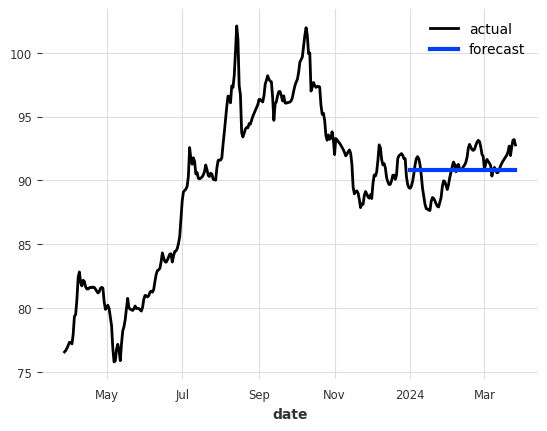

In [181]:
from darts.models import Croston

model_croston = Croston(version="tsb", alpha_d=0.1, alpha_p=0.1)
model_croston.fit(train)
prediction_croston = model_croston.predict(len(val))

filled_series.plot(label="actual")
prediction_croston.plot(label="forecast", lw=3)
plt.legend()

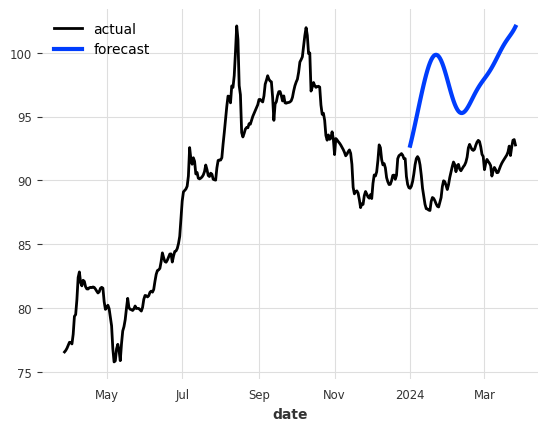

In [130]:
from darts.models import FFT

model_fft = FFT(nr_freqs_to_keep=20, trend="exp")
model_fft.fit(train)
prediction_fft = model_fft.predict(len(val))

filled_series.plot(label="actual")
prediction_fft.plot(label="forecast", lw=3)
plt.legend()

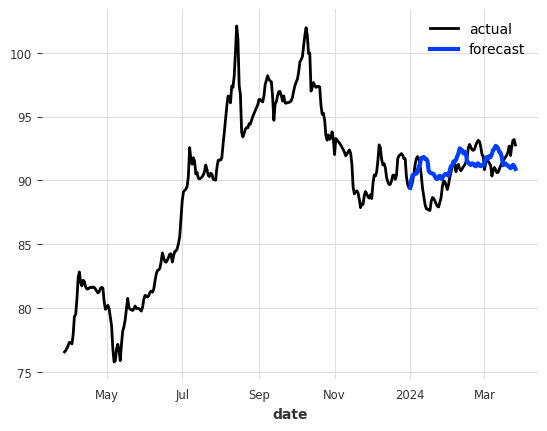

In [187]:
from darts.models import KalmanForecaster

model_k = KalmanForecaster(dim_x=30)
model_k.fit(train, future_covariates=future_cov)
prediction_k = model_k.predict(len(val), future_covariates=future_cov)

filled_series.plot(label="actual")
prediction_k.plot(label="forecast", lw=3)
plt.legend()